In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Enable inline plotting
%matplotlib inline

# Configuration
gpu_counts = [1, 2, 3, 4]
data_dir = Path('H100/spec_power_motif')
power_caps = [800,900,1000,1100,1200,1400,1700,2000]

In [9]:
def calculate_metrics(benchmark, gpu_count, power_cap):
    """
    Calculate performance and energy consumption for a given configuration.
    Performance = 1 / execution_time (from runtime.csv)
    Energy = average_power × execution_time (only for active GPUs)
    """
    csv_file = data_dir / benchmark / f"{power_cap}_{gpu_count}_gpu_metrics.csv"
    
    if not csv_file.exists():
        return None, None
    
    try:
        df = pd.read_csv(csv_file)
        
        if len(df) < 2:
            return None, None
        
        # Get runtime from runtime.csv
        runtime_file = data_dir / benchmark / 'runtime.csv'
        if runtime_file.exists():
            df_runtime = pd.read_csv(runtime_file)
            # Find the matching row
            match = df_runtime[(df_runtime['power_cap'] == power_cap) & 
                              (df_runtime['gpu_count'] == gpu_count)]
            if len(match) > 0:
                execution_time = match.iloc[0]['runtime_seconds']
            else:
                # Fallback to GPU metrics file
                execution_time = df['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0]
        else:
            execution_time = df['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0]
        
        # Calculate performance (inverse of execution time)
        performance = 1.0 / execution_time if execution_time > 0 else 0
        
        # Calculate energy: average_power × time (only for active GPUs)
        energy = 0.0
        for i in range(gpu_count):
            power_col = f'GPU{i}_Power (W)'
            if power_col in df.columns:
                avg_power = df[power_col].mean()
                energy += avg_power * execution_time
        
        return performance, energy
    
    except Exception as e:
        print(f"Error processing {csv_file}: {e}")
        return None, None

    
def collect_data():
    """Collect all data for the benchmarks."""
    data = {}
    
    for benchmark in benchmarks:
        data[benchmark] = {}
        
        for gpu_count in gpu_counts:
            performances = []
            energies = []
            valid_caps = []
            
            for power_cap in power_caps:
                perf, energy = calculate_metrics(benchmark, gpu_count, power_cap)
                
                if perf is not None and energy is not None:
                    performances.append(perf)
                    energies.append(energy)
                    valid_caps.append(power_cap)
            
            if performances:
                data[benchmark][gpu_count] = {
                    'power_caps': valid_caps,
                    'performance': np.array(performances),
                    'energy': np.array(energies)
                }
    
    return data

def normalize_data(data):
    """Normalize performance and energy to the baseline (highest power cap)."""
    normalized_data = {}
    
    for benchmark in data:
        normalized_data[benchmark] = {}
        
        for gpu_count in data[benchmark]:
            perf = data[benchmark][gpu_count]['performance']
            energy = data[benchmark][gpu_count]['energy']
            
            # Normalize to the highest power cap (last element when sorted)
            if len(perf) > 0:
                # Find the baseline (highest power cap)
                baseline_idx = np.argmax(data[benchmark][gpu_count]['power_caps'])
                baseline_perf = perf[baseline_idx]
                baseline_energy = energy[baseline_idx]
                
                normalized_data[benchmark][gpu_count] = {
                    'power_caps': data[benchmark][gpu_count]['power_caps'],
                    'performance': perf / baseline_perf,
                    'energy': energy / baseline_energy
                }
    
    return normalized_data


def plot_performance(benchmarks_to_plot):
    """
    Plot normalized performance as grouped bar charts.
    For each benchmark, create a subplot for each power cap case.
    Each subplot shows 4 bars representing different GPU counts.
    """
    for benchmark in benchmarks_to_plot:
        # Collect all power caps across all GPU counts for this benchmark
        all_caps = set()
        for gpu_count in gpu_counts:
            if gpu_count in data[benchmark]:
                all_caps.update(data[benchmark][gpu_count]['power_caps'])
        
        all_caps = sorted(list(all_caps))
        n_caps = len(all_caps)
        
        # Create grid layout (e.g., 4 columns)
        n_cols = 4
        n_rows = int(np.ceil(n_caps / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
        fig.suptitle(f'{benchmark.upper()} - Normalized Runtime (baseline: 1 GPU)', fontsize=16, fontweight='bold')
        
        # Flatten axes array for easier indexing
        axes = axes.flatten() if n_caps > 1 else [axes]
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for cap_idx, power_cap in enumerate(all_caps):
            ax = axes[cap_idx]
            
            # Collect runtime data for this power cap across all GPU counts
            x_pos = np.arange(len(gpu_counts))
            normalized_runtime_values = []
            
            # Get baseline (1 GPU runtime for this power cap)
            baseline_runtime = None
            if 1 in data[benchmark]:
                caps_1gpu = data[benchmark][1]['power_caps']
                perf_1gpu = data[benchmark][1]['performance']
                runtime_1gpu = 1.0 / perf_1gpu
                
                if power_cap in caps_1gpu:
                    cap_to_runtime = dict(zip(caps_1gpu, runtime_1gpu))
                    baseline_runtime = cap_to_runtime[power_cap]
            
            for gpu_count in gpu_counts:
                if gpu_count in data[benchmark] and baseline_runtime is not None:
                    caps = data[benchmark][gpu_count]['power_caps']
                    perf = data[benchmark][gpu_count]['performance']
                    runtime = 1.0 / perf
                    
                    # Find runtime for this power cap
                    if power_cap in caps:
                        cap_to_runtime = dict(zip(caps, runtime))
                        normalized_runtime_values.append(cap_to_runtime[power_cap] / baseline_runtime)
                    else:
                        normalized_runtime_values.append(0)
                else:
                    normalized_runtime_values.append(0)
            
            # Plot bars
            bars = ax.bar(x_pos, normalized_runtime_values, color=colors, alpha=0.8)
            
            # Formatting
            ax.set_xticks(x_pos)
            ax.set_xticklabels([f'{g}GPU' for g in gpu_counts], fontsize=9)
            ax.set_title(f'{power_cap}W', fontsize=11, fontweight='bold')
            ax.set_ylabel('Normalized Runtime', fontsize=9)
            # ax.set_ylim([0.2, 1.5])
            ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
            ax.grid(True, alpha=0.2, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}',
                           ha='center', va='bottom', fontsize=8)
        
        # Hide empty subplots
        for idx in range(n_caps, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

def plot_energy(benchmarks_to_plot):
    """
    Plot normalized energy consumption as grouped bar charts.
    Normalized to 1 GPU case for each power cap.
    For each benchmark, create a subplot for each power cap case.
    Each subplot shows 4 bars representing different GPU counts.
    """
    for benchmark in benchmarks_to_plot:
        # Collect all power caps across all GPU counts for this benchmark
        all_caps = set()
        for gpu_count in gpu_counts:
            if gpu_count in data[benchmark]:
                all_caps.update(data[benchmark][gpu_count]['power_caps'])
        
        all_caps = sorted(list(all_caps))
        n_caps = len(all_caps)
        
        # Create grid layout (e.g., 4 columns)
        n_cols = 4
        n_rows = int(np.ceil(n_caps / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
        fig.suptitle(f'{benchmark.upper()} - Normalized Energy (baseline: 1 GPU)', fontsize=16, fontweight='bold')
        
        # Flatten axes array for easier indexing
        axes = axes.flatten() if n_caps > 1 else [axes]
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for cap_idx, power_cap in enumerate(all_caps):
            ax = axes[cap_idx]
            
            # Collect energy data for this power cap across all GPU counts
            x_pos = np.arange(len(gpu_counts))
            normalized_energy_values = []
            
            # Get baseline (1 GPU energy for this power cap)
            baseline_energy = None
            if 1 in data[benchmark]:
                caps_1gpu = data[benchmark][1]['power_caps']
                energy_1gpu = data[benchmark][1]['energy']
                
                if power_cap in caps_1gpu:
                    cap_to_energy = dict(zip(caps_1gpu, energy_1gpu))
                    baseline_energy = cap_to_energy[power_cap]
            
            for gpu_count in gpu_counts:
                if gpu_count in data[benchmark] and baseline_energy is not None:
                    caps = data[benchmark][gpu_count]['power_caps']
                    energy = data[benchmark][gpu_count]['energy']
                    
                    # Find energy for this power cap
                    if power_cap in caps:
                        cap_to_energy = dict(zip(caps, energy))
                        normalized_energy_values.append(cap_to_energy[power_cap] / baseline_energy)
                    else:
                        normalized_energy_values.append(0)
                else:
                    normalized_energy_values.append(0)
            
            # Plot bars
            bars = ax.bar(x_pos, normalized_energy_values, color=colors, alpha=0.8)
            
            # Formatting
            ax.set_xticks(x_pos)
            ax.set_xticklabels([f'{g}GPU' for g in gpu_counts], fontsize=9)
            ax.set_title(f'{power_cap}W', fontsize=11, fontweight='bold')
            ax.set_ylabel('Normalized Energy', fontsize=9)
            # ax.set_ylim([0.7, 2])
            ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
            ax.grid(True, alpha=0.2, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}',
                           ha='center', va='bottom', fontsize=8)
        
        # Hide empty subplots
        for idx in range(n_caps, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()


def plot_edp(benchmarks_to_plot):
    """
    Plot normalized EDP (Energy-Delay Product) as grouped bar charts.
    EDP = Energy × Time
    Normalized to 1 GPU case for each power cap.
    For each benchmark, create a subplot for each power cap case.
    Each subplot shows 4 bars representing different GPU counts.
    """
    for benchmark in benchmarks_to_plot:
        # Collect all power caps across all GPU counts for this benchmark
        all_caps = set()
        for gpu_count in gpu_counts:
            if gpu_count in data[benchmark]:
                all_caps.update(data[benchmark][gpu_count]['power_caps'])
        
        all_caps = sorted(list(all_caps))
        n_caps = len(all_caps)
        
        # Create grid layout (e.g., 4 columns)
        n_cols = 4
        n_rows = int(np.ceil(n_caps / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
        fig.suptitle(f'{benchmark.upper()} - Normalized EDP (baseline: 1 GPU)', fontsize=16, fontweight='bold')
        
        # Flatten axes array for easier indexing
        axes = axes.flatten() if n_caps > 1 else [axes]
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for cap_idx, power_cap in enumerate(all_caps):
            ax = axes[cap_idx]
            
            # Collect EDP data for this power cap across all GPU counts
            x_pos = np.arange(len(gpu_counts))
            normalized_edp_values = []
            
            # Get baseline (1 GPU EDP for this power cap)
            baseline_edp = None
            if 1 in data[benchmark]:
                caps_1gpu = data[benchmark][1]['power_caps']
                perf_1gpu = data[benchmark][1]['performance']
                energy_1gpu = data[benchmark][1]['energy']
                runtime_1gpu = 1.0 / perf_1gpu
                edp_1gpu = energy_1gpu * runtime_1gpu * runtime_1gpu
                
                if power_cap in caps_1gpu:
                    cap_to_edp = dict(zip(caps_1gpu, edp_1gpu))
                    baseline_edp = cap_to_edp[power_cap]
            
            for gpu_count in gpu_counts:
                if gpu_count in data[benchmark] and baseline_edp is not None:
                    caps = data[benchmark][gpu_count]['power_caps']
                    perf = data[benchmark][gpu_count]['performance']
                    energy = data[benchmark][gpu_count]['energy']
                    runtime = 1.0 / perf
                    edp = energy * runtime * runtime
                    
                    # Find EDP for this power cap
                    if power_cap in caps:
                        cap_to_edp = dict(zip(caps, edp))
                        normalized_edp_values.append(cap_to_edp[power_cap] / baseline_edp)
                    else:
                        normalized_edp_values.append(0)
                else:
                    normalized_edp_values.append(0)
            
            # Plot bars
            bars = ax.bar(x_pos, normalized_edp_values, color=colors, alpha=0.8)
            
            # Formatting
            ax.set_xticks(x_pos)
            ax.set_xticklabels([f'{g}GPU' for g in gpu_counts], fontsize=9)
            ax.set_title(f'{power_cap}W', fontsize=11, fontweight='bold')
            ax.set_ylabel('Normalized EDP', fontsize=9)
            # ax.set_ylim([0, 1.5])
            ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
            ax.grid(True, alpha=0.2, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}',
                           ha='center', va='bottom', fontsize=8)
        
        # Hide empty subplots
        for idx in range(n_caps, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()


def plot_combined_metrics(benchmarks_to_plot):

    for benchmark in benchmarks_to_plot:
        # Collect all power caps across all GPU counts for this benchmark
        all_caps = set()
        for gpu_count in gpu_counts:
            if gpu_count in data[benchmark]:
                all_caps.update(data[benchmark][gpu_count]['power_caps'])
        
        all_caps = sorted(list(all_caps))
        n_caps = len(all_caps)
        
        # Create grid layout: 3 rows (metrics) × n_caps columns (power caps)
        n_cols = n_caps
        n_rows = 3
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
        # Get max power info (4 GPUs @ 2000W)
        max_power_info = ""
        if 4 in data[benchmark] and 2000 in data[benchmark][4]['power_caps']:
            csv_file = data_dir / benchmark / f"2000_4_gpu_metrics.csv"
            if csv_file.exists():
                df = pd.read_csv(csv_file)
                # Find max power across all GPUs and all time steps
                max_gpu_power = 0
                for i in range(4):
                    power_col = f'GPU{i}_Power (W)'
                    if power_col in df.columns:
                        gpu_max = df[power_col].max()
                        max_gpu_power = max(max_gpu_power, gpu_max)
            max_power_info = f" | Max Power per GPU: {max_gpu_power:.1f}W ({max_gpu_power*4:.0f}W total)"

        fig.suptitle(f'{benchmark.upper()}{max_power_info}', 
                    fontsize=16, fontweight='bold', y=1.02)


        
        # Handle single column case
        if n_caps == 1:
            axes = axes.reshape(-1, 1)
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        metric_names = ['Runtime', 'Energy', 'EDP']
        
        for cap_idx, power_cap in enumerate(all_caps):
            # Get baseline values (1 GPU) for this power cap
            baseline_runtime = None
            baseline_energy = None
            baseline_edp = None
            
            if 1 in data[benchmark]:
                caps_1gpu = data[benchmark][1]['power_caps']
                perf_1gpu = data[benchmark][1]['performance']
                energy_1gpu = data[benchmark][1]['energy']
                runtime_1gpu = 1.0 / perf_1gpu
                edp_1gpu = energy_1gpu * runtime_1gpu
                
                if power_cap in caps_1gpu:
                    idx = caps_1gpu.index(power_cap)
                    baseline_runtime = runtime_1gpu[idx]
                    baseline_energy = energy_1gpu[idx]
                    baseline_edp = edp_1gpu[idx]
            
            # Collect data for all GPU counts at this power cap
            x_pos = np.arange(len(gpu_counts))
            runtime_values = []
            energy_values = []
            edp_values = []
            
            for gpu_count in gpu_counts:
                if gpu_count in data[benchmark]:
                    caps = data[benchmark][gpu_count]['power_caps']
                    perf = data[benchmark][gpu_count]['performance']
                    energy = data[benchmark][gpu_count]['energy']
                    runtime = 1.0 / perf
                    edp = energy * runtime
                    
                    if power_cap in caps:
                        idx = caps.index(power_cap)
                        if baseline_runtime is not None:
                            runtime_values.append(runtime[idx] / baseline_runtime)
                            energy_values.append(energy[idx] / baseline_energy)
                            edp_values.append(edp[idx] / baseline_edp)
                        else:
                            runtime_values.append(0)
                            energy_values.append(0)
                            edp_values.append(0)
                    else:
                        runtime_values.append(0)
                        energy_values.append(0)
                        edp_values.append(0)
                else:
                    runtime_values.append(0)
                    energy_values.append(0)
                    edp_values.append(0)
            
            # Plot all three metrics for this power cap
            metrics_data = [runtime_values, energy_values, edp_values]
            
            for metric_idx, (metric_name, metric_values) in enumerate(zip(metric_names, metrics_data)):
                ax = axes[metric_idx, cap_idx]
                
                # Store actual values before clipping
                actual_values = metric_values.copy()
                
                # Clip values for display
                clipped_values = [min(v, 5) if v > 0 else 0 for v in metric_values]
                
                # Plot bars with clipped values
                bars = ax.bar(x_pos, clipped_values, color=colors, alpha=0.8)
                
                # Formatting
                ax.set_xticks(x_pos)
                ax.set_xticklabels([f'{g}' for g in gpu_counts], fontsize=9)
                
                # Only show xlabel on bottom row
                if metric_idx == 2:
                    ax.set_xlabel('# GPUs', fontsize=12)
                
                # Only show power cap title on top row
                if metric_idx == 0:
                    ax.set_title(f'{power_cap}W', fontsize=11, fontweight='bold')
                
                # Only show ylabel on leftmost column
                if cap_idx == 0:
                    ax.set_ylabel(f'Norm. {metric_name}', fontsize=12)
                
                # ax.set_ylim([0, 1.1])
                ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
                ax.grid(True, alpha=0.2, axis='y')
                
                # Add value labels on bars showing actual values
                for i, bar in enumerate(bars):
                    actual_val = actual_values[i]
                    if actual_val > 0:
                        # Position at top of clipped bar
                        y_pos = min(actual_val, 5)
                        ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                               f'{actual_val:.2f}',
                               ha='center', va='bottom', fontsize=12)
        
        plt.subplots_adjust(hspace=0.4, wspace=0.3, top=0.95, bottom=0.05)
        plt.show()


In [11]:
benchmarks = ['pot3d','minisweep','lbm', 'cloverleaf', 'tealeaf','hpgmg','miniweather']
# benchmarks = ['minisweep','lbm', 'cloverleaf', 'tealeaf']
data = collect_data()
normalized_data = normalize_data(data)

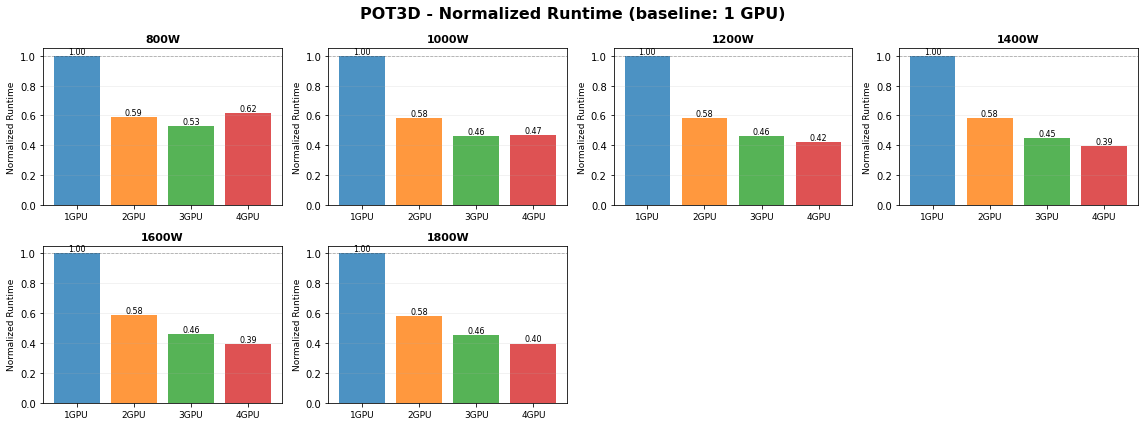

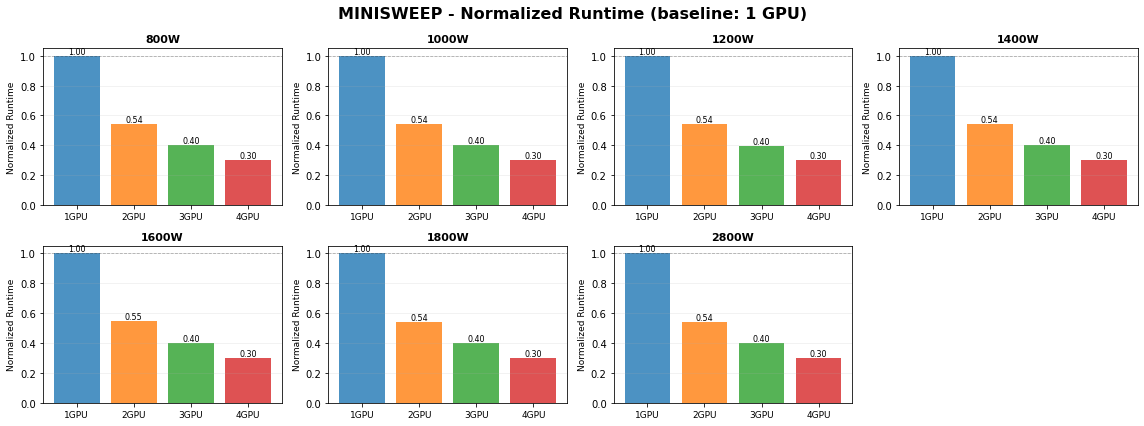

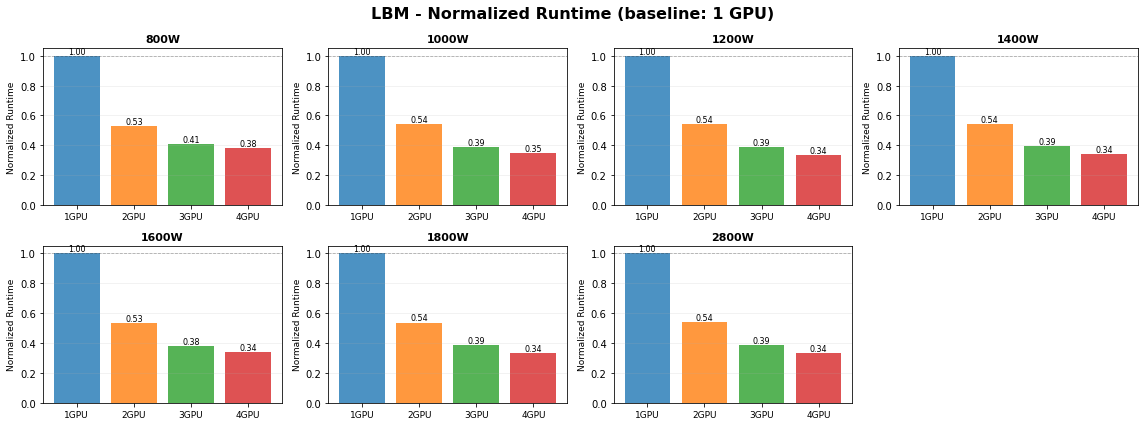

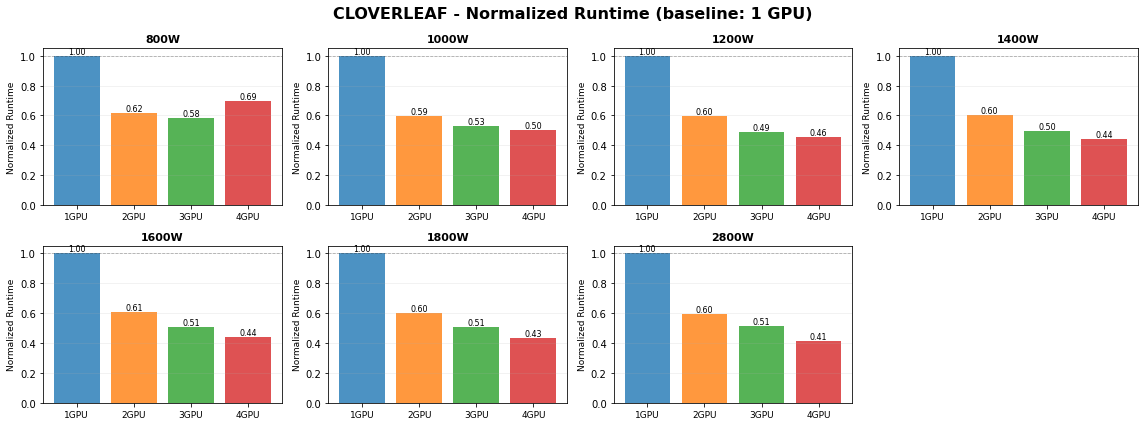

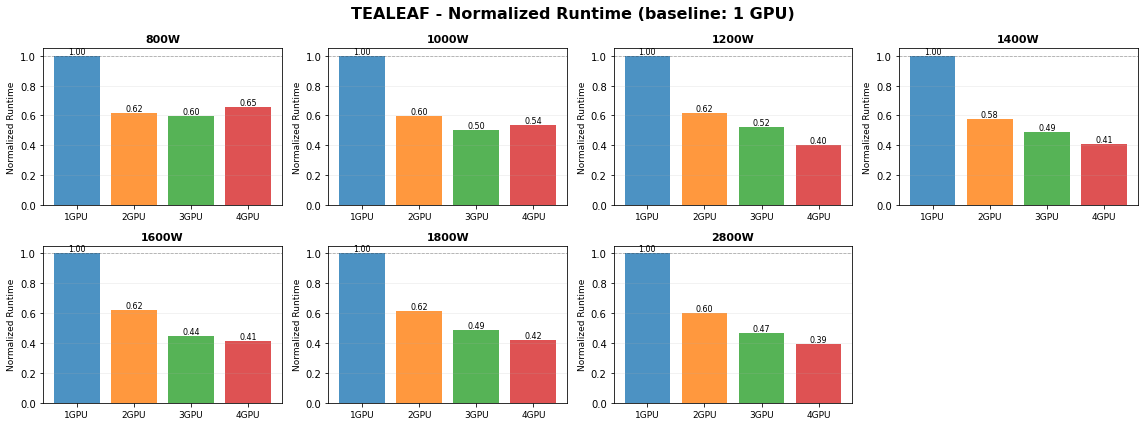

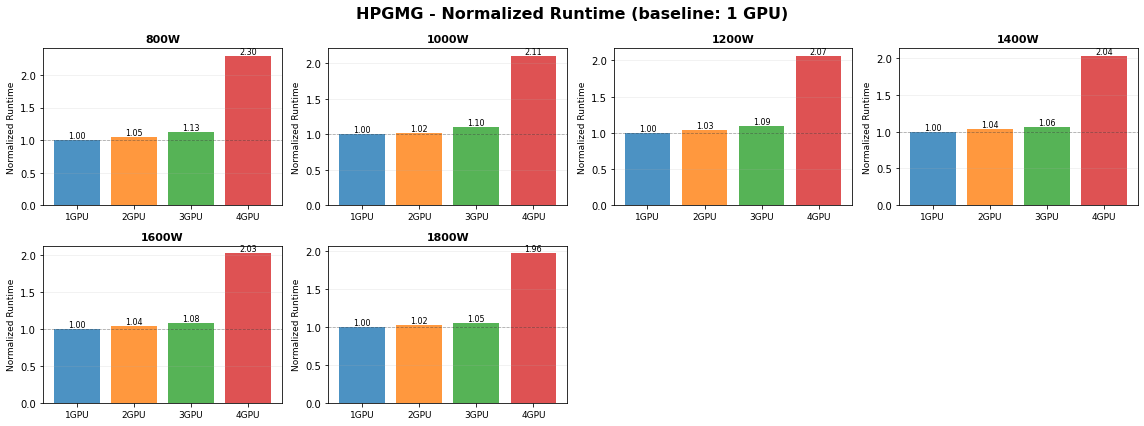

In [33]:
plot_performance(benchmarks)

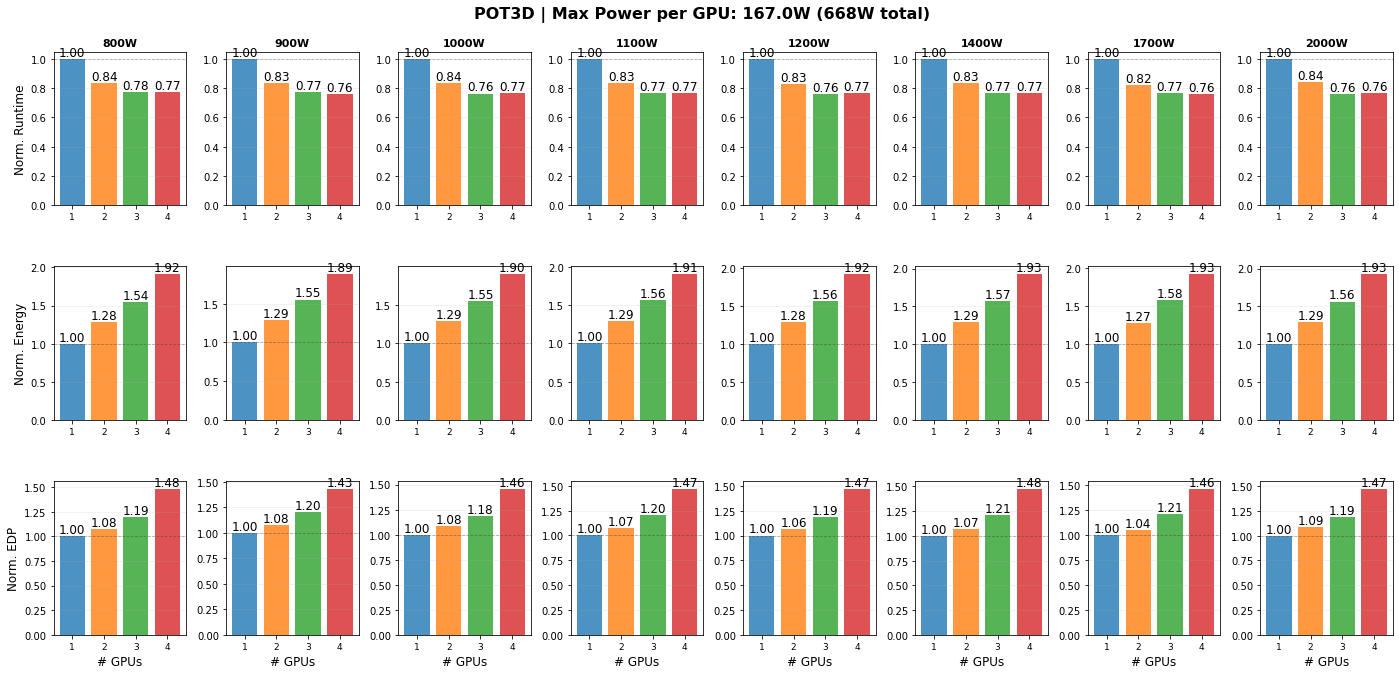

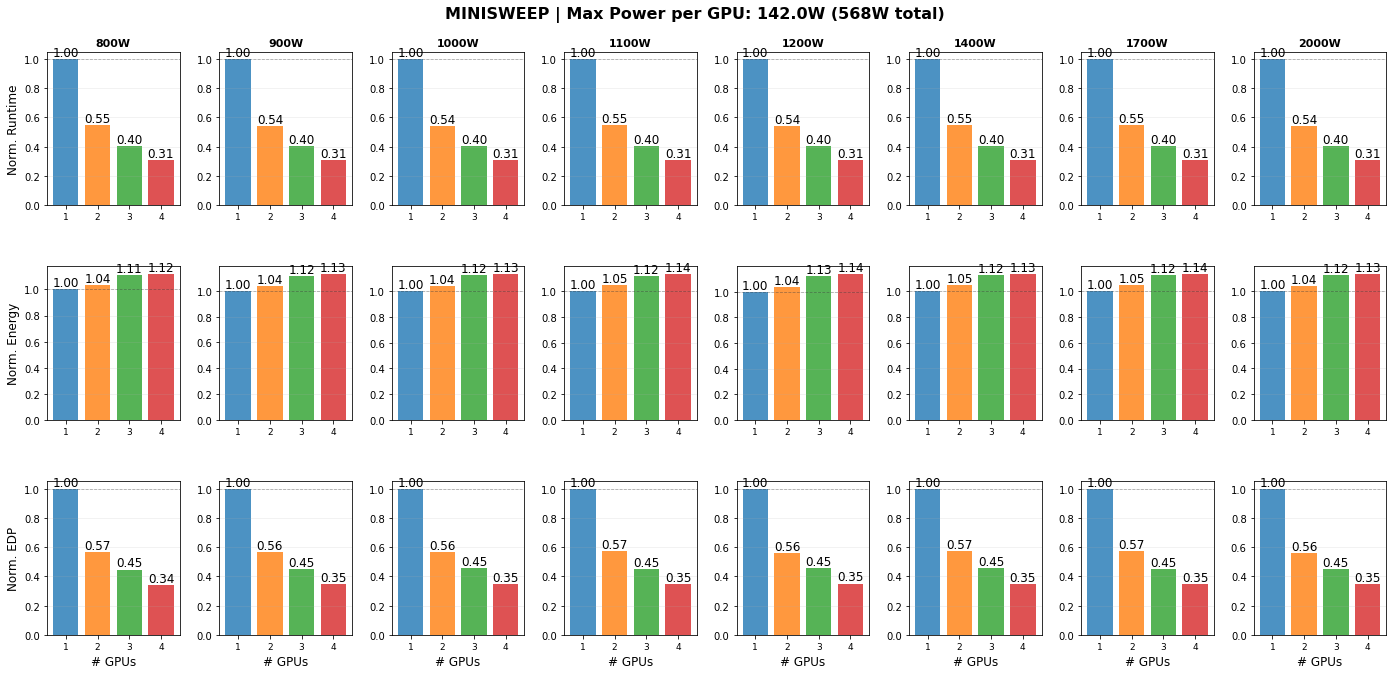

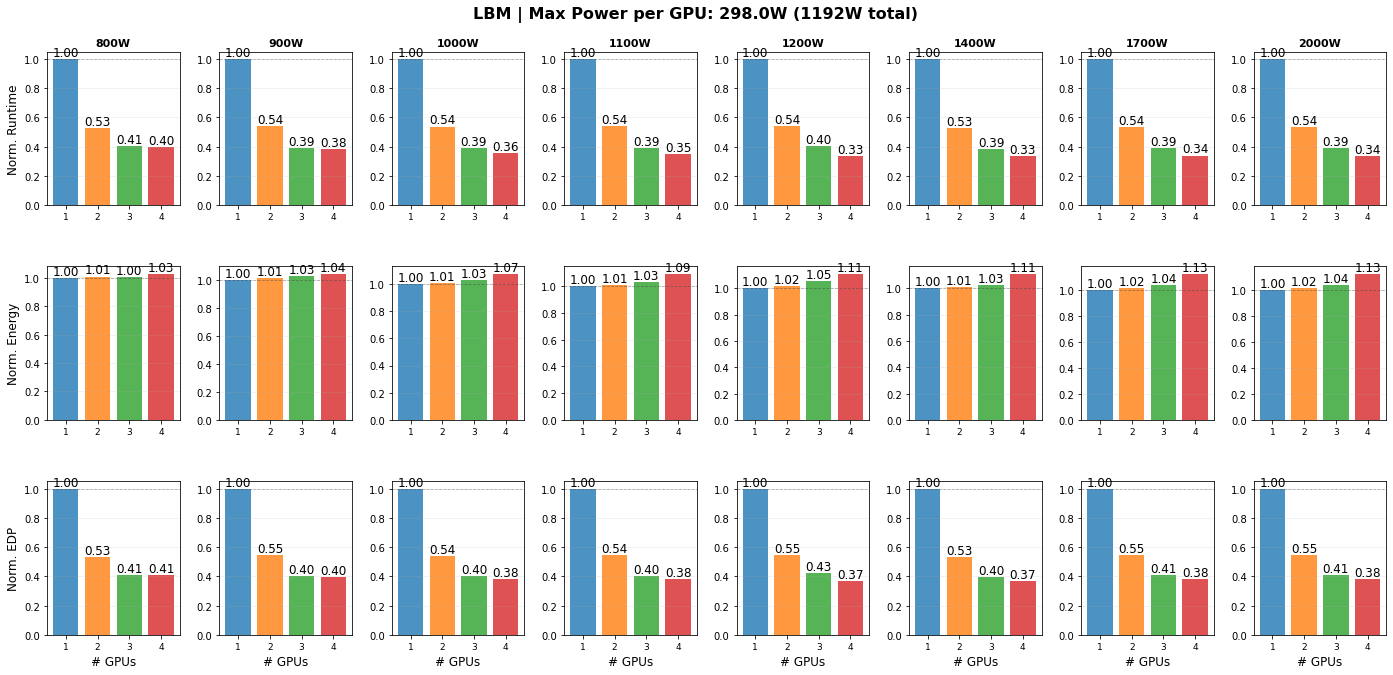

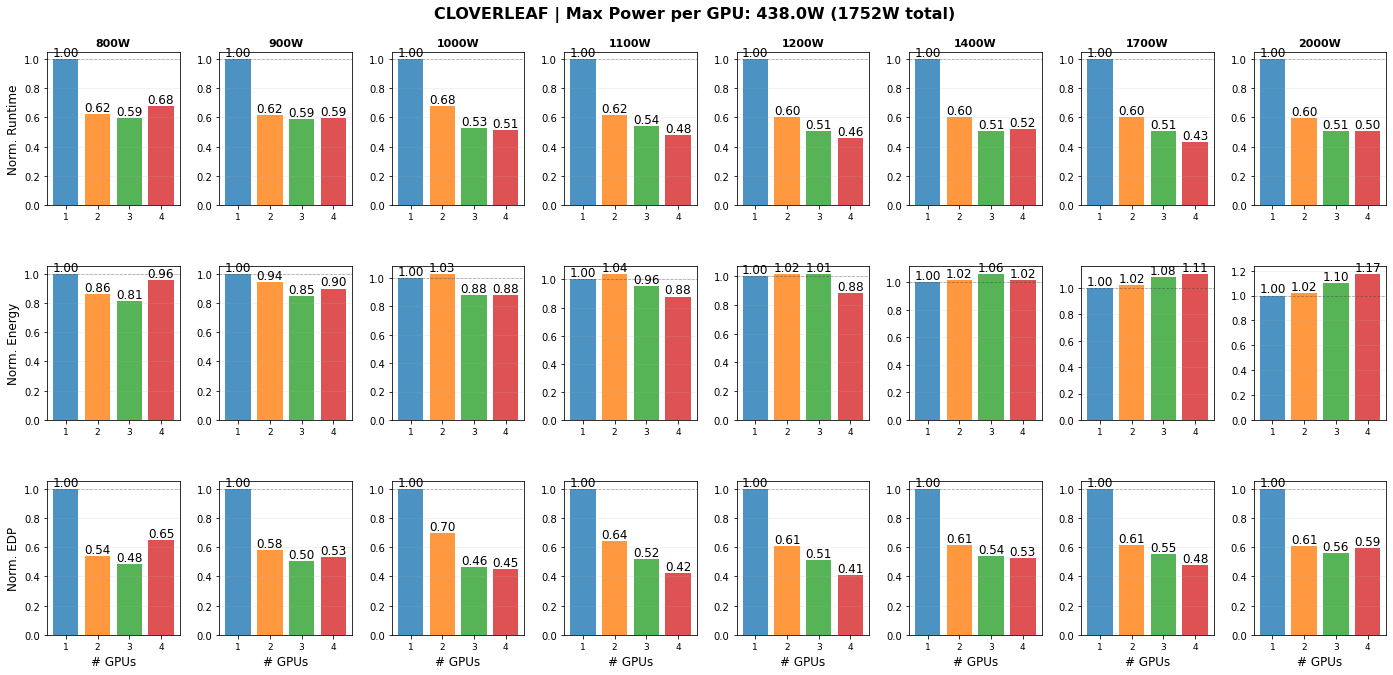

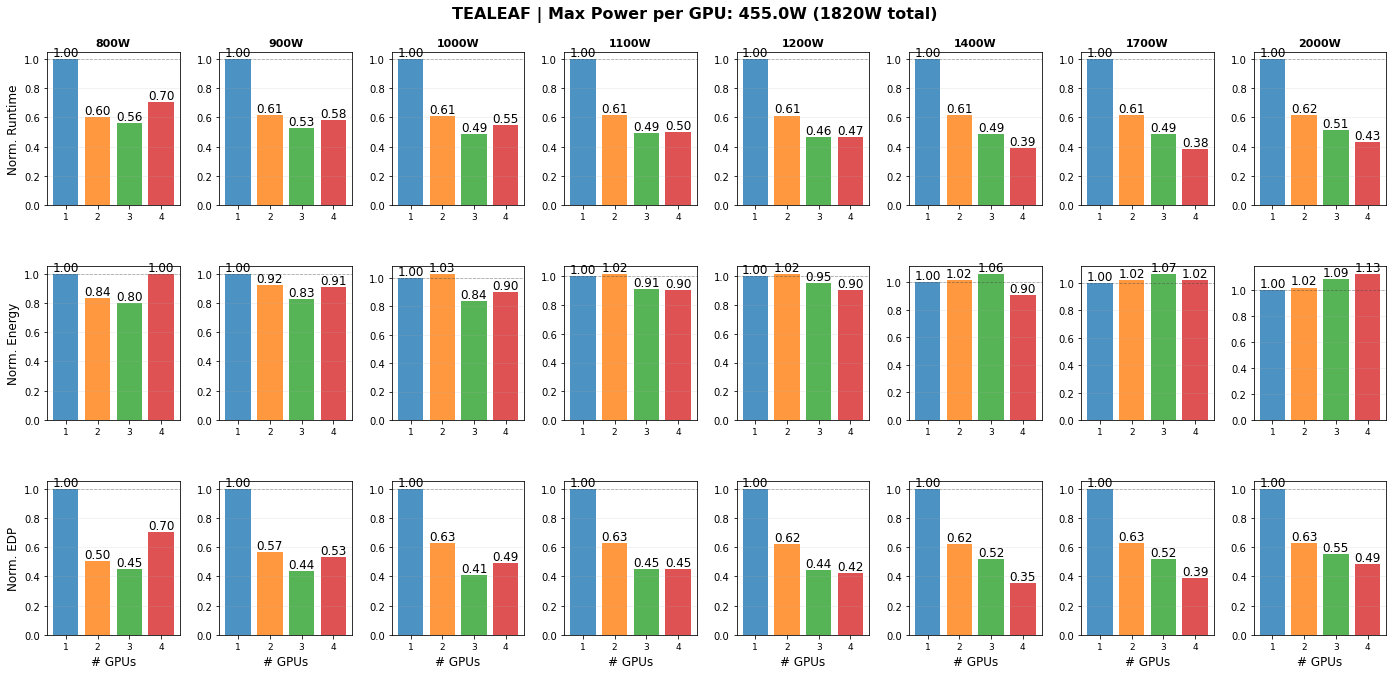

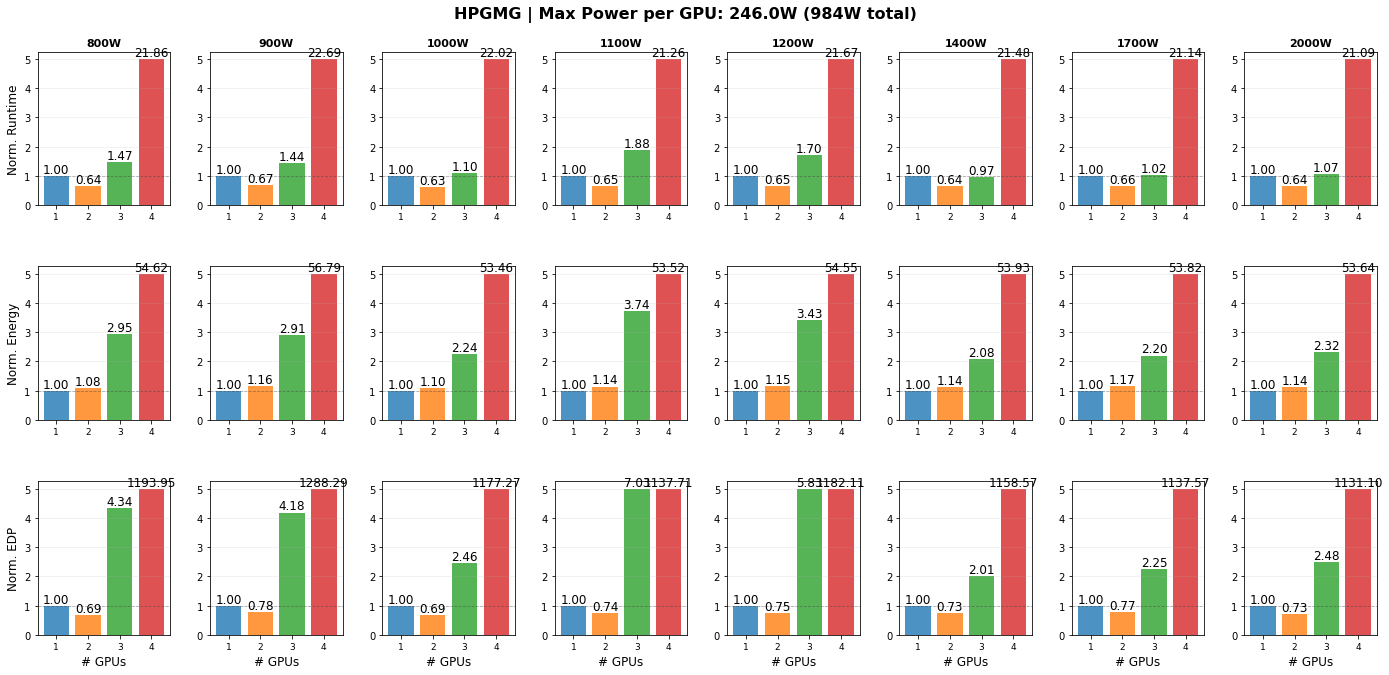

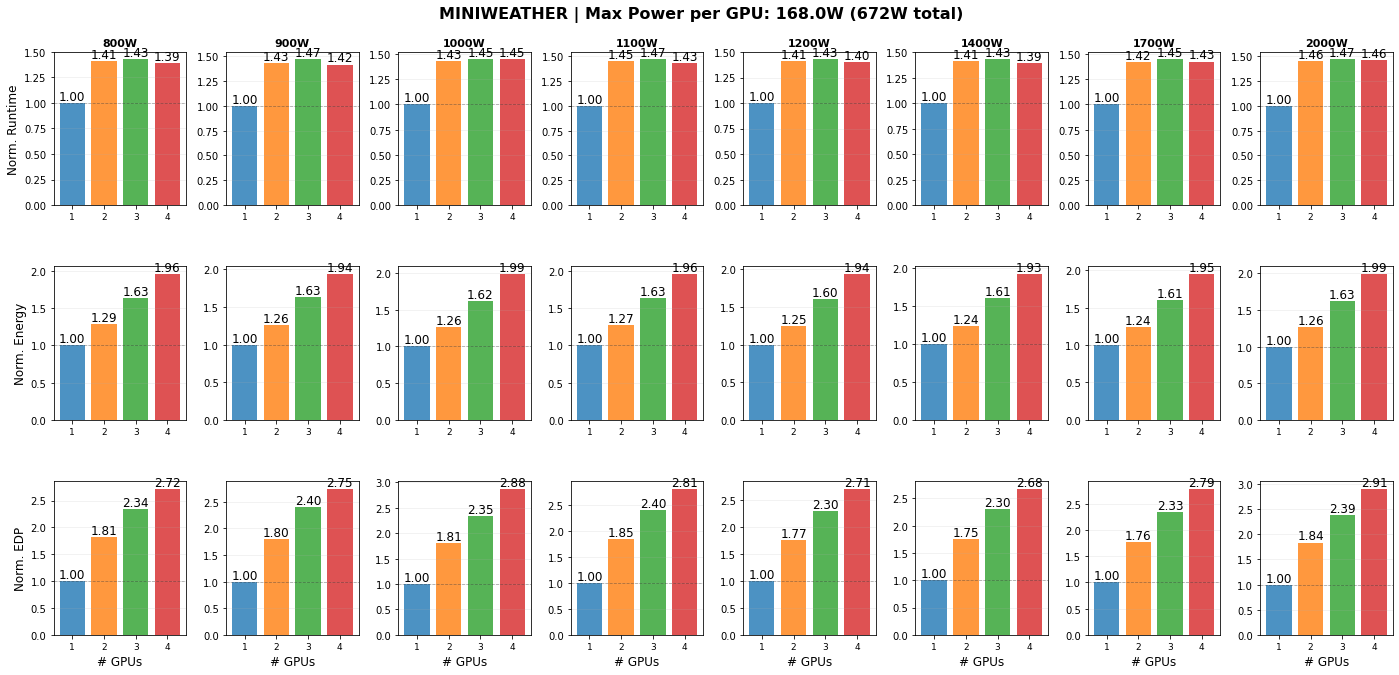

In [12]:
plot_combined_metrics(benchmarks)

# Sensitivity

gpu1: 1900, 0.76
gpu2: 2912, 1.26
gpu3: 3345, 1.41
gpu4: 3364, 1.12